# Seals On Ice: Mapping ice habitat for harbor seals in tidewater glacier fjords
## Quantifying ice change in Kenai Fjords National Park through monthly acquisitions using fixed wing aircraft and aerial photos.


#### _National Park Service, Alaska Regional Office, Scientist in Parks Program_

This Jupyter Notebook includes background for a habitat monitoring project, outlines our analytical workflow, and annotates image processing steps to accompany python code and ArcGIS outputs. By using a shareable format like a Jupyter Notebook, the steps in our remote sensing/GIS processing can be better understood and modified for similar projects by other researchers.

Graham Brady, Chad Hults, Deb Kurtz

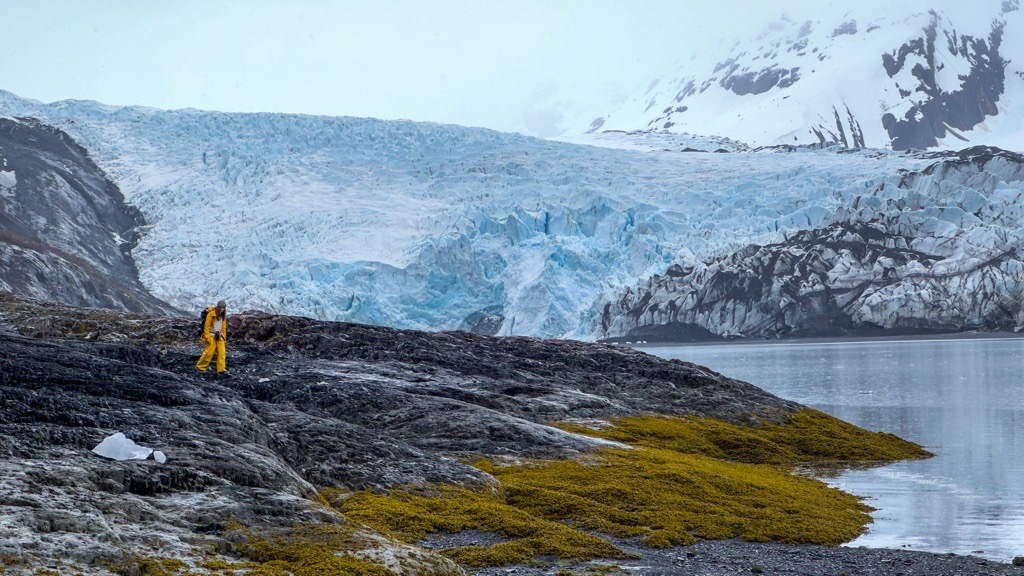



## Background



Our project considers temporal change in habitat for harbor seals over the course of a pupping season. Seals rely on icebergs to haul out, seeking protection from predators during pupping and molting

The National Park Service Alaska Regional Office contracted an analyst to develop a mapping technique through Scientists-in-Parks, an Americorps program that engages young talent with projects accross disciplines in agencies that manage protected land in the United States. The Kenai Fjords Tidewater Glaciers Ice Habitat project seeks to measure change in ice habitat over the summer season to supplement understandings of harbor seal longevity in a dynamic glacial environment confronted with climate change.

In addition to acquisition planning and execution, the Scientists-in-Parks position focused on developing a standalone method to map available ice habitat in three tidewater glacier fjord study areas using aerial imagery. Images were collected during multiple fixed-wing aircraft misions during the summer calving season of the glaciers  in 2023. During this first year of acquisitions, sufficient data were gathered over McCarty Fjord, Northwestern Fjord, and Aialik Bay. 

This notebook includes processing steps applied to mosaic imagery for May, July, and August 2023 produced using a modified Structure-From-Motion photogrammetry workflow in Agisoft Metashape. Thematic maps of habitable ice were then created using this remote sensing/GIS workflow in ArcGIS Pro and used to assess temporal change over the course of the summer in each study area. In the future, this workflow will be applied to additional acquisitions in the same study areas in 2024 and 2025.


## Methods

### Acquisition

Air photo acquisition took place according to established methods at the Alaska Regional Office of the National Park service (cite). Using a Cessna 206H outfitted with underside camera ports and a G8 antenna, aerial surveys were flown along predetermined flightlines to take photos over the glacier, fjord, and nearby mountains with 80% overlap and 60% sidelap. An intervalometer attached to a Nikon D850 camera with 35mm lens allowed for photos to be taken with these coverage parameters. With a modified hot-shoe connector, camera shutters were linked to a Trimble Alloy GNSS receiver to trigger events during a 10Hz logging session at the same time a photo was taken.

### Structure-from-Motion Processing

Processing of raw air photos includes two main stages: production of a three-band orthoimage and thematic mapping of that orthoimage. Air photos were linked to a survey grade point in space from which they were taken. A table of these file names and reference points were added to Agisoft Metashape in the Alaksa State Plane Zone 4 coordinate system using the North American Datum 1983 epoch 2011. 

Photos were aligned using the software's standard tool which searches for matches in overlapping photographs (tie points). Because water and floating ice are not stationary during the period of photo acquisition, tie points of these types were deleted to increase the accuracy of the camera calibration; by optimizing camera variables to the subset of tie points that represent true, stationary matches, the resultant DEM and orthomosaic are thus more accurate over land.

However, because there are minimal areas over water to find matches between photos, it was necessary to hydroflatten the water bodies and icebergs. Production of the orthophoto used the "mosaic" method within Agisoft Metashape to blend boundaries between photos for the final stitched product.

### Thematic Mapping of Icebergs

Several methods of image classification and GIS processing were attempted before developing a finalized workflow. While individual images could be robustly mapped using a particular approach, few of these approaches were successful for multiple fjords or months of acquisitions. However, leveraging the positive aspects of prior attempts proved helpful for develping a solution that worked for many acquisitions. Because of changing lighting conditions, variability in ice density, and differences in surface water appearance, it was necessary to develop a workflow that produces accurate thematic maps to compare available ice area with minimal alteration or input from an analyst beyond project setup.

The Jupyter Notebook format incorporates blocks of codes and annotations to document processing, show results, and provide a way to share workflows wither others. While developing the image classification workflow for this project, stages were written in Python code format and the final version is included below.

Most of the geoprocessing for this workflow utilizes ESRI's ArcPy library of classes and methods, which blend standard python techniques and syntax with a simple set of tools that resemble the organization of ArcMap and ArcGIS Pro geoprocessing tools. With an understanding of the way these tools work and some creativity, the Jupyter Notebook is an optimal environment through which to develop and improve an analytical workflow, particularly in a repetitive way. With the ability to quickly cycle through parameters we were able to determine the optimal settings and combinations of variables with which to produce the best result across acquisitions



## Analyzing the Imagery

### Stage 0: Preparing the Environment


#### Importing libraries and setting filepaths to directories for reading and writing of data


Python is powerful because of the ability to load open source libraries created by other users and groups that are tailored to particular uses. Ranging from data analysis, computer vision, statistics, and graphing libraries, research developed using python often combines multiple libraries to create simple, efficient solutions.

The __SealsOnIce__ workflow relies on access to ESRI licensing and was developed using ArcGIS Pro. Therefore, the main workhorse of the processing steps is `arcpy`, an ESRI library that transitions geoprocessing tools to a scripting format to analyze and map data without using the graphical interface of ArcGIS Pro. Because NPS researchers have enterprise access to this software, we chose to use this service for our workflow because it is an easy, reproducable way to share our research approach with the ability to also carry out the same steps without a coding background. In future developments of this workflow, it is recommended to redevelop image analysis and geoprocessing stages solely using open-source software pacakges to maximize the accessiblity of this workflow and decrease reliance on ESRI software that not all researchers can use.

To setup the `arcpy` environment, it is necessary to assign a working directory, project, and map. Using the main project folder and its subdirectories, we can do that.

In [45]:
import arcpy
import os
import numpy as np
import pandas as pd

The `os` library contains methods to interact with the file explorer and manipulate paths while retaining proper formatting. `os.path.join()` is an example of a method, implemented above to access subdirectories of the main project folder `proj_folder =  r'F:\KEFJ_TidewaterGlaciers_Analysis'`.

Another useful method is `os.walk()`, which will recursively return the contents of a given directory. This allows for processing within all subdirectories of data. In our case we can use this to apply the same workflow across all acquisitions if we structure our data storage as follows:

- Analysis Folder
    - 2023_05_18_Acquisitions
        - McCarty
        - Northwestern
        - Aialik
    - 2023_07_13_Acquisitions
        - McCarty
        - Northwestern
        - Aialik
    - 2023_08_18_Acquisitions
        - McCarty
        - Northwestern
        - Aialik
        
We can run `os.listdirs(r'F:\KEFJ_TidewaterGlaciers_Analysis')` to return objects for each aquisition folder, and proceed to apply the same steps to those folder objects. To make sure we only get the directories and not additional lingering files, we must subset the result using a conditional. Additionally we subset away the main __Arc__ folder, since that will not contain any acquisition-specific data.

In [46]:
main_folder = r'F:\KEFJ_TidewaterGlaciers_Analysis'
year_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f)) and f != 'Arc' and f != 'Results']
study_areas = [f for f in os.listdir(os.path.join(main_folder, year_folders[0])) if os.path.isdir(os.path.join(main_folder, year_folders[0], f))]

Use `year_folders` to show the available months and years acquired.

In [47]:
year_folders

['August_2023', 'July_2023', 'May_2023']

In [48]:
study_areas

['Aialik', 'McCarty', 'Northwestern']

Using a List Comprehension technique, the year folders within the main folder are subset for just directories (dirs) not named 'Arc'. From this point, we look for additional dirs within each year folder, check that they are dirs not files, and concatenate them to a flattened list of acquisitions.

In [49]:
acquisitions = []
for year_folder in year_folders:
    acquisitions.append([os.path.join(main_folder, year_folder, f) for f in os.listdir(os.path.join(main_folder, year_folder)) if os.path.isdir(os.path.join(main_folder, year_folder, f))])
    study_areas = [f for f in os.listdir(os.path.join(main_folder, year_folder)) if os.path.isdir(os.path.join(main_folder, year_folder, f))]
acquisitions = [item for row in acquisitions for item in row] #flatten the list of lists from above loop
print('The following acquisitions have been found in the main folder', main_folder, ':')
print()
for i in acquisitions:
    print(i)

The following acquisitions have been found in the main folder F:\KEFJ_TidewaterGlaciers_Analysis :

F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Northwestern
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\Northwestern
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\Northwestern


We will keep track of results for long term comparisons between fjords and months by creating a data frame to store ice areas and abundances per acquisition. These will be referred to with the variable `results`.

In [26]:
results = pd.DataFrame(columns=('month', 'fjord','ice_area_sqkm', 'iceberg_count','aoi_area_sqkm','processing_time'))

def append_row(df, row): #define the function to be used to join this standard dataframe and new result rows.
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

The above list of columns may change down the line, but for now we will process an acquisition and add the results to this data frame in the same order.

When a new acquisition is ready to process, visit this section of the workbook to reassign variables and run the workflow again.

In [27]:
acquisition = acquisitions[0] #increase this number to change acquisitions

print('The following will be analyzed:')

print(acquisition)

The following will be analyzed:
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Aialik


Keep in mind the messages coming from each cell in this workbook as you click through the geoprocessing steps of the workflow. Sometimes, the map being referenced must be open in ArcGIS Pro in order for the tools to properly work. This is the most likely error to encounter. Be sure to open the maps as they are created and close them when finished. It will help you to watch the mapping unfold, too. To keep track of the processing times, let's also create a timer that runs while our analysis goes.

In [28]:
import time
startTime = time.perf_counter()
#startTime variable will hold this place and be referenced again at the end of the analysis.

### Stage 1: Image Segmentation

In [29]:
_, _, year_folder, study_area = acquisition.split('\\')
year_folder, study_area

('August_2023', 'Aialik')

Check the split of the filepath to make sure all the files will be read and written correctly.

In [30]:
layerPrefix = year_folder + '_' + study_area + '_' #this prefix will help identify similar data products between acquisitions
map_query = study_area + ' ' + year_folder + ' BandStack Classification'
map_query

'Aialik August_2023 BandStack Classification'

In [31]:
#proj_folder = acquisition
proj_folder =  os.path.join(main_folder, year_folder, study_area)
data_path = os.path.join(proj_folder, 'Image_RGB') #folder containing RGB image
dst_path = os.path.join(proj_folder, 'Classification\Layers')
shapes_path = os.path.join(proj_folder, 'Classification\Shapes')
chart_dst = os.path.join(proj_folder, 'Classification\Charts')
project_gdb = os.path.join(proj_folder, 'Arc','KEFJ_TidewaterGlaciers_Analysis.gdb')

#### Assigning variable names for the current acquisition

Because the same workflow will be applied to each acquisition's folder, it is necessary to create a naming convention that adds descriptors after a general stem. Within the folder, each RGB image is located in the same subdirectory and the outputs are to be written in the same subdirectory. For example, the RGB image will be gathered by searching for a .tif file whose name ends in _Image_RGB.tif_ in the __Image_RGB__ folder and will calculate and write a bandstack with name _Bandstack_Value_NDWI_BNDVI.tif_ in the __Layers__ folder. These file names can be distinguised by adding _KEFJ_Northwestern_July_2023_ as a prefix. We can retrieve the proper prefix from the original names of the acquisition folders during our setup. Additionally, steps later on in can access the same types of intermediary rasters to continue the analysis without having to alter much of the code during setup.


In [32]:
arcpy.env.workspace = data_path
arcpy.env.overwriteOutput = True
aprx = arcpy.mp.ArcGISProject("Current")
if len(aprx.listMaps(map_query)) == 0:
    m = aprx.createMap(map_query) #create new map
else: m = aprx.listMaps(map_query)[0]

Use a search query from the chosen folder names to find the filename of the RGB image.

In [33]:
#rgb_filename = '2023_07_13_KEFJ_McCarty_ImageRGB.tif'
files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('tif')]
rgb_filename = files[0]
rgb_filename

'2023_08_18_KEFJ_Aialik_ImageRGB.tif'

We need to use similar logic to search for and import the clip shape.

In [54]:
files = [f for f in os.listdir(shapes_path) if os.path.isfile(os.path.join(shapes_path, f)) and f.endswith('shp')]
mask_filename = files[0]
mask_filename

'2023_08_18_KEFJ_Aialik_IceClip.shp'

Add the two files to the newly created map.

In [62]:
image_rgb = m.addDataFromPath(os.path.join(main_folder,proj_folder,data_path,rgb_filename))
mask = m.addDataFromPath(os.path.join(main_folder,proj_folder,shapes_path,mask_filename))

#mask.name = 'Ice Clip'

If a Buffer is needed, create one and differentiate between the two layers named "Ice Clip"

In [63]:
buffered_mask = arcpy.analysis.Buffer(
    in_features=mask,
    out_feature_class=os.path.join(main_folder,proj_folder,shapes_path,mask_filename[:-4]+'_buffer2m'+mask_filename[-4:]),
    buffer_distance_or_field="-2 Meters",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="PLANAR"
)

Set whether to use buffer or not:

In [65]:
useBuffer = True

In [67]:
mask = m.listLayers('*IceClip')[0] 
buffered_mask = m.listLayers('*IceClip_buffer*')[0]

if useBuffer:
    m.removeLayer(mask)
    mask = buffered_mask
else:
    m.removeLayer(mask)

Once the read and write paths for data for the particular acquisition to be processared are defined in `arcpy`, we start to work within an environment similar to a Map in ArcGISPro. We start by adjusting the symbology of the mask layer and applying a clip.

In [70]:
mask.name='Ice Clip'
sym = mask.symbology
sym.renderer.symbol.applySymbolFromGallery("Black Outline (2 pts)")
sym.renderer.symbol.outlineColor = {'RGB' : [255, 0, 0, 255]} #rgbalpha
mask.symbology = sym #apply red to original layer
rgb = arcpy.sa.Raster(rgb_filename) #create a raster object from the filename loaded into the map
image_rgb.name = 'Image RGB'
rgb_clip = arcpy.ia.Clip(rgb, aoi = mask.name) #clip the raster
rgb_clip.save(os.path.join(dst_path, layerPrefix+'IceAreaClip.tif')) #save the clipped raster to the destination path with the proper name

In [69]:
#save area of AOI for later reference
arcpy.management.CalculateGeometryAttributes(
    in_features=mask,
    geometry_property="area_sqkm AREA",
    length_unit="",
    area_unit="SQUARE_KILOMETERS",
    coordinate_system='PROJCS["NAD_1983_2011_StatePlane_Alaska_4_FIPS_5004",GEOGCS["GCS_NAD_1983_2011",DATUM["D_NAD_1983_2011",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-150.0],PARAMETER["Scale_Factor",0.9999],PARAMETER["Latitude_Of_Origin",54.0],UNIT["Meter",1.0]],VERTCS["unknown",VDATUM["unknown"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]',
    coordinate_format="SAME_AS_INPUT"
)

polygons = []

rows = arcpy.SearchCursor(mask)
for row in rows:
    area = row.getValue("area_sqkm")
    polygons.append(area)

aoi_area_sqkm = round(sum(polygons), 2)

#### Producing relevant raster layers from input data

After importing the data, 

In [71]:
RGB = rgb_clip

b1, b2, b3 = RGB.getRasterBands()
NullBinaryRaster = arcpy.sa.RasterCalculator([b1,b2,b3],['b1','b2','b3'],'(b1 == 0) & (b2 == 0) & (b3 == 0)')
NullBinaryRaster.save('nullBinaryRaster.tif')
arcpy.CompositeBands_management(';'.join([str(NullBinaryRaster.catalogPath)]*RGB.bandCount),
                                "nullBandRasterStack.tif")
#arcpy.management.CalculateStatistics("nullBandRasterStack.tif")
RGB2 = arcpy.sa.SetNull("nullBandRasterStack.tif", RGB, 'Value = 1')
#m.removeLayer(m.listLayers('nullBandRasterStack.tif')[0])

In [72]:
RGB = arcpy.sa.Raster(RGB2)
m.listLayers('RGB2')[0].name = 'Clipped RGB'

Band arithmetic is a common tool derive additional rasters in remote sensing data analysis. Also known as map algebra or band math in other software, the result of this two is a raster whose values represent the result of the expression for each cell in one or more input rasters. With rasters of different shape, cell size adjustments are necessary. However, in this context, we are operating on multiple bands of the same input raster, _Image_RGB_. In other circumstances, we might combine data from several sources to calculate temperature from radiance and emissivity. 

For our project, we developed several normalized band indices to accentuate differences in land cover and subdue differences in lighting conditions. These indices were modified from established indices featured in studies using calibrated sensors. For example, satellite bands calibrated for reflectance produce accurate and precise measurements for vegetation productivity with the Normalized Difference Vegetation Index (NDVI). While our cameras are not calibrated, the object based segmentation method in our workflow weights local differences in pixel values, supporting our use of these modified indices.

In [73]:
ndwi = arcpy.sa.BandArithmetic(RGB, "(B2-B1)/(B2+B1)", 0)
ndwi.save(os.path.join(dst_path, layerPrefix+'NDWI.tif'))

bndvi = arcpy.sa.BandArithmetic(RGB, "(B1-B3)/(B1+B3)", 0)
bndvi.save(os.path.join(dst_path, layerPrefix+'BNDVI.tif'))

endvi = arcpy.sa.BandArithmetic(RGB, "((B1+B2)-(2*B3))/((B1+B2)+(2*B3))", 0)
endvi.save(os.path.join(dst_path, layerPrefix+'ENDVI.tif'))

After calculating the rasters from the RGB image, we add them to the map and assign each as a raster object.

In [74]:
bndvi_r = m.addDataFromPath(os.path.join(dst_path, layerPrefix+'BNDVI.tif'))
endvi_r = m.addDataFromPath(os.path.join(dst_path, layerPrefix+'ENDVI.tif'))
ndwi_r = m.addDataFromPath(os.path.join(dst_path, layerPrefix+'NDWI.tif'))

ndwi = arcpy.sa.Raster(m.listLayers('*NDWI*')[0].dataSource)
bndvi = arcpy.sa.Raster(m.listLayers('*BNDVI*')[0].dataSource)
endvi = arcpy.sa.Raster(m.listLayers('*ENDVI*')[0].dataSource)

ndwi_r.name = 'NDWI'
bndvi_r.name = 'BNDVI'
endvi_r.name = 'ENDVI'

Jamie Womble's research group conducted a similar study in Glacier Bay National Park and Preserve using imagery gathered by UAS. Their analysis converted the imagery from RGB colorspace to hue, saturation, and value (HSV). The value band of this colorspace corresponds to the brightness level for pixels. Because ice is significantly brighter than surrounding water, the value raster lends useful for a quick thresholding step by which to discriminate ice and water. 

While in some attempts a single threshold number of the value raster led to a successful thematic map, our team found it difficult to develop an automated method of calculating an image-specific threshold number for the value raster using sampled training points. However, because of the usefulness of this raster layer at highlighting the differences between ice and water, we included these value rasters in the bandstack that is fed into the segmentation tool.

In [75]:
out_hsv_3bands = arcpy.sa.ColorspaceConversion(RGB, "rgb_to_hsv") #convert RGB image to HSV
out_hsv_3bands.save(os.path.join(dst_path, layerPrefix+'hsv_3bands.tif')) #save HSV image

m.addDataFromPath(os.path.join(dst_path, layerPrefix+'hsv_3bands.tif')) #add HSV image to map

value = arcpy.sa.Raster(layerPrefix+'hsv_3bands.tif') #create raster object for hsv raster
h, s, v = value.getRasterBands() #enumerate the three bands of the image, with v (value) being the band of interest

To leverage the best qualities of each derived band, we create a new three band composite raster for the Value, BNDVI, and ENDVI rasters.

In [76]:
arcpy.management.CompositeBands([v, bndvi, endvi], os.path.join(dst_path, layerPrefix+'Val_Bndvi_Endvi_Composite.tif')) #create a bandstack of the three bands
bs_clip = arcpy.ia.Clip(arcpy.sa.Raster(layerPrefix+'Val_Bndvi_Endvi_Composite.tif'), aoi = mask.name) #clip the bandstack once more to remove and NoData pixels around the edges
bs_clip.save(os.path.join(dst_path, layerPrefix+'Val_Bndvi_Endvi_Composite_IceClip.tif')) #save the clipped bandstack 

After adding the bandstack clipped to the area of interest and creating a raster object, set the parameters for the segmentation algorithm and run the tool to produce a shapefile of likely ice polygons. Some clean up will be needed, but the preliminary segmentation result includes polygons of all sizes that were created using the segment mean shift method.

In [77]:
BandStack_Clipped = m.addDataFromPath(os.path.join(dst_path, layerPrefix+'Val_Bndvi_Endvi_Composite_IceClip.tif')) #add the clipped raster to the map
m.removeLayer(m.listLayers(layerPrefix+'hsv_3bands.tif')[0])
m.removeLayer(m.listLayers(layerPrefix+'Val_Bndvi_Endvi_Composite.tif')[0])

In [78]:
r = arcpy.sa.Raster(layerPrefix+'Val_Bndvi_Endvi_Composite_IceClip.tif') #assign a raster object


#set the segmentation settings
spectral = 10
spatial = 10
minSize = 25

segmented = arcpy.ia.SegmentMeanShift(r, spectral, spatial, minSize, '', -1)
segmented.save(os.path.join(dst_path, layerPrefix+'BandStack_ValueBNDVIENDVI_Segmentation' + str(spectral) + '_' + str(spatial) +'_'+ str(minSize) + '.tif'))

arcpy.conversion.RasterToPolygon(segmented, os.path.join(shapes_path, layerPrefix+'BandStack_ValueBNDVIENDVI_Segmentation' + str(spectral) + '_' + str(spatial) +'_'+ str(minSize) +'_polygonsIceClip.shp'), "NO_SIMPLIFY", "Value", "SINGLE_OUTER_PART", None)
m.removeLayer(m.listLayers(layerPrefix+'BandStack_ValueBNDVIENDVI_Segmentation' + str(spectral) + '_' + str(spatial) +'_'+ str(minSize) +'_polygonsIceClip')[0])


In [79]:
m.removeLayer(m.listLayers('segmented')[0])

### Stage 2: Polygon Refinement



Now that the preliminary thematic map has been produced and converted to polygon format, polygons need to be attributed and  cleaned. Size thresholds must be applied to subset the result to include ice habitable by harbor seals. Jaimie Womble's group notes that this size threshold is greater than 1.6 square meters.


To refine the polygons, we need to also remove any suspected water polygons using size and mean brightness (value) thresholds.

#### Running the workflow

Once again, we can use the directory organization to our advantage by accessing the name of the acquisition folder and year that we are currently processing.

In [80]:
#these should all be the same from the first stage
aprx = arcpy.mp.ArcGISProject("CURRENT") #set ArcGISPro project

segmentation_result_path = os.path.join(shapes_path, layerPrefix+'BandStack_ValueBNDVIENDVI_Segmentation' + str(spectral) + '_' + str(spatial) +'_'+ str(minSize) +'_polygonsIceClip.shp') #assign path to polygons
image_rgb_path = os.path.join(data_path, rgb_filename) #assign RGB image path
value_raster_path = os.path.join(dst_path, layerPrefix+'hsv_3bands.tif\Band_3') #assign value raster path

A new map is created and relevant data added. We need to retrive the names of files, folders, and databases from the segmentation phase of the workflow.

In [81]:
refinement_map = m

In [82]:
#if len(aprx.listMaps(study_area + " " + year_folder + " Ice Classification Refinement")) == 0:
#    refinement_map = aprx.createMap(study_area + " " + year_folder + " Ice Classification Refinement") #create new map
#else: refinement_map = aprx.listMaps(study_area + " " + year_folder + " Ice Classification Refinement")[0]

#img_rgb = refinement_map.addDataFromPath(image_rgb_path) #add RGB image for basemap
#img_rgb.name = 'Image_RGB' #change display name
BandStack_Clipped.name = 'Clipped Bandstack Raster'
val = refinement_map.addDataFromPath(value_raster_path) #add value raster for zonal statistics and refinement
val.name = 'Value Raster' #change display name
seg_result = refinement_map.addDataFromPath(segmentation_result_path) #add segmented polygons
seg_result.name = 'Segmentation Result' #change display name

In [83]:
segmentation_result = seg_result.name #assign current name for reference to the polygon layer in the catalog
value_raster = val.name #assign current name for reference to the value layer in the catalog

area_subset = year_folder + study_area + '_Refined_AreaSubset'
zonal_stats_table = year_folder + study_area + '_ValueZonalStats_QC_AreaSubset'
near_table = year_folder + study_area + '_QC_AreaSub_NearTable'

gdb = r"F:\KEFJ_TidewaterGlaciers_Analysis\Arc\KEFJ_TidewaterGlaciers_Analysis.gdb"

Calculate geometry attributes in State Plane Zone 4 with NAD1983 Epoch 2011.

In [84]:
arcpy.management.CalculateGeometryAttributes(
    in_features=seg_result,
    geometry_property="area_sqm AREA",
    length_unit="",
    area_unit="SQUARE_METERS",
    coordinate_system='PROJCS["NAD_1983_2011_StatePlane_Alaska_4_FIPS_5004",GEOGCS["GCS_NAD_1983_2011",DATUM["D_NAD_1983_2011",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-150.0],PARAMETER["Scale_Factor",0.9999],PARAMETER["Latitude_Of_Origin",54.0],UNIT["Meter",1.0]],VERTCS["unknown",VDATUM["unknown"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]',
    coordinate_format="SAME_AS_INPUT"
)

<Result 'Segmentation Result'>

After calculating geometry attributes for each polygon, the features are subset and exported to include polygons larger than the minimum size threshold and smaller than an extemely large threshold. Since the segmentation algorithm does not assign any designation as ice, water, or other, it is assumed that the largest polygon represents the majority of the water in the study area. From tests, deleting this largest polygon results in a subset of very likely ice polygons with further clean up of small areas of submerged ice and water pockets adjacent to ice.

In [85]:
arcpy.conversion.FeatureClassToFeatureClass(
    in_features= seg_result,
    out_path=gdb,
    out_name= area_subset,
    where_clause="area_sqm >= 1.6 And area_sqm < 3000",
    config_keyword=""
)
area_sub = refinement_map.listLayers(area_subset)[0] #assign variable to subset lyr

Symbology is also applied for the subset polygons and the original result for ease of identification should this workbook be run with an ArcGIS Pro window open at the same time.

In [86]:
sym = seg_result.symbology
sym.renderer.symbol.applySymbolFromGallery("Black Outline (2 pts)")
sym.renderer.symbol.outlineColor = {'RGB' : [255, 0, 0, 255]} #rgb alpha
seg_result.symbology = sym #apply red to original layer
sym.renderer.symbol.outlineColor = {'RGB' : [0, 255, 0, 255]}
area_sub.symbology = sym #apply green to subset layer

The remainder of polygons must be cleaned according to their pixel values. By calculating zonal statistics for the polygons and considering the distribution of those values, a threshold can be determined to coarsely refine the polygons and remove likely water polygons. Results of the zonal statistics tool are joined to the polygon layer and a histogram is created.

In [87]:
arcpy.ia.ZonalStatisticsAsTable( #produce zonal stats for the mean value for each polygon
    in_zone_data=area_subset,
    zone_field="Id",
    in_value_raster= value_raster,
    out_table=os.path.join(gdb, zonal_stats_table),
    ignore_nodata="DATA",
    statistics_type="ALL",
    process_as_multidimensional="CURRENT_SLICE",
    percentile_values=[90,75],
    percentile_interpolation_type="LINEAR"
)

arcpy.management.JoinField( #join zonal stats to area refined table
    in_data=area_subset,
    in_field="Id",
    join_table=zonal_stats_table,
    join_field="Id",
    fields=None
)

<Result 'May_2023Aialik_Refined_AreaSubset'>

A final, fine adjustment to the ice polygons is required to remove polygons that were mapped due to their proximity to true ice polygons. Using a near table that searches for touching polygons, a similar thresholding step is applied.

In [88]:
arcpy.analysis.GenerateNearTable(
    in_features=area_subset,
    near_features=area_subset,
    out_table=os.path.join(gdb, near_table),
    search_radius="0 Meters", #adjacent, touching polygons
    location="NO_LOCATION",
    angle="NO_ANGLE",
    closest="ALL",
    closest_count=0,
    method="PLANAR"
)

# JOIN NEAR TABLE RESULTS TO AREA SUBSET
arcpy.management.JoinField(
    in_data=near_table,
    in_field="IN_FID",
    join_table=area_subset,
    join_field="OBJECTID",
    fields="MEAN",
)
arcpy.management.JoinField( #adds "MEAN_1 to the table, which is the mean_val of the NEAR polygon."
    in_data=near_table,
    in_field="NEAR_FID",
    join_table=area_subset,
    join_field="OBJECTID",
    fields="MEAN"
)
#change names of fields for user ease
arcpy.management.AlterField(near_table,
                            "MEAN",
                            "origin_mean",
                            "origin_mean")
arcpy.management.AlterField(near_table,
                            "MEAN_1",
                            "near_mean",
                            "near_mean")

<Result 'May_2023Aialik_QC_AreaSub_NearTable'>

After joining and renaming the fields from the near table to the polygon layer, a new metric is required to compare the values of two adjacent polygons. From tests, this normalized difference variant seems to help distinguish polygons that are markedly lower in mean brightness from their neighbor. Subsetting polygons with a positive value for this comparison metric fosuses on polygons lower then their neighbor.

In [89]:
arcpy.management.CalculateField(
    in_table=near_table,
    field="difference",
    expression="(!origin_mean!-!near_mean!)/(!origin_mean!+!near_mean!)",
    expression_type="PYTHON3",
    code_block="",
    field_type="DOUBLE",
    enforce_domains="NO_ENFORCE_DOMAINS"
)
arcpy.management.SelectLayerByAttribute( #selects polygons where the adjacent polygon is lower.
    in_layer_or_view=near_table,
    selection_type="NEW_SELECTION",
    where_clause="difference > 0",
    invert_where_clause=None
)
arcpy.management.JoinField(
    in_data=area_sub,
    in_field="OBJECTID",
    join_table=near_table,
    join_field="NEAR_FID",
    fields=None
)

<Result 'May_2023Aialik_Refined_AreaSubset'>

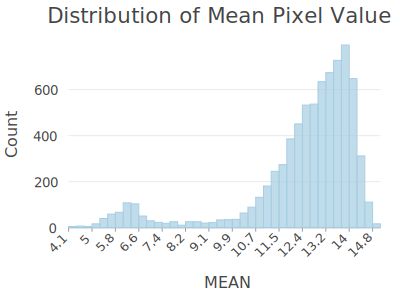

In [90]:
area_sub = refinement_map.listLayers(area_subset)[0]
mean_val_chart = arcpy.charts.Histogram("MEAN", binCount=40)
mean_val_chart.dataSource = area_sub
mean_val_chart.title = "Distribution of Mean Pixel Value"
mean_val_chart.addToLayer(area_sub)
#mean_val_chart.exportToSVG("mean_val_hist.svg", width=1000, height=800)
mean_val_chart

Producing an additional histogram  of this difference metric helps to determine the threshold value to carryout the last stage of data refinement based on pixel values before producing final histograms for iceberg area distribution for the acquisition.

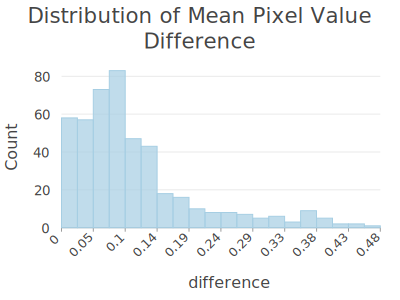

In [91]:
val_dif_chart = arcpy.charts.Histogram("difference", binCount=20)
val_dif_chart.dataSource = area_sub
val_dif_chart.title = "Distribution of Mean Pixel Value Difference"
val_dif_chart.addToLayer(area_sub)
val_dif_chart

After using the histograms to determine the coarse and fine threshold values to subset the polygons based on mean pixel brightness values, we apply those thresholds in an export step and resymbolize.

### Stage 3: Mean Brightness Clean-Up

The current workflow finishes the refinement stage with a manual choosing of threshold value for the mean brightness of each polygons and the comparative brightness of touching polygons. Previous experiments with polygon classification exposed a clear pattern of a bimodal distribution of mean pixel brightness for the polygons. A higher-value, brighter cluster represents polygons of true ice, while a lower-value, darker cluster represents polygons that were segmented over water or submerged ice. The easiest way to clean out these segmented polygons over water was to determine a value under which polygons could confidently be attributed as non-ice. This stage of the workflow does not currently employ an automated determination of the threshold value, so it lacks reproduceability and allows for error to be introduced by the analyst.

Below, the code selects polygons based on these manual values. Determine the two values by observing the distributions in the above histograms.

In [92]:
#use descriptive statistics to get values
arcpy.SelectLayerByAttribute_management(area_subset, "CLEAR_SELECTION")
arcpy.conversion.FeatureClassToFeatureClass(
    in_features=area_subset,
    out_path=gdb,
    out_name=area_subset + '_final_refined',
    where_clause="MEAN >= 9 Or difference < .2", #input stats here for thresholds
    config_keyword=""
)
sym = area_sub.symbology
sym.renderer.symbol.applySymbolFromGallery("Black Outline (2 pts)")
sym.renderer.symbol.outlineColor = {'RGB' : [255, 255, 0, 255]} #rgbalpha
area_sub.symbology = sym #apply red to original layer

In [93]:
ndwi_r.visible = False
endvi_r.visible = False
bndvi_r.visible = False
val.visible = False
BandStack_Clipped.visible = False

### Stage 4: Final Products

Specifically, we requested for each month of data in each fjord in 2023:

- histogram
- number of individual polygons
- ice area total (sq km)
- ice area percent coverage (please combine the info for these last three bullets into an .xls spreadsheet)
- raster showing density of ice per moving average sq. km 

We also discussed creating a geodatabase with the mean pixel value and area for each polygon and the acquisition date and times.

In [94]:
fc = refinement_map.listLayers('*Refined_AreaSubset_final_refined*')[0]
count_of_icebergs = arcpy.management.GetCount(fc)

process_time = time.strftime("%H:%M:%S", 
                             time.gmtime(round(time.perf_counter() - startTime, 1)))

#area of ice
icebergs = []

rows = arcpy.SearchCursor(fc)
for row in rows:
    area = row.getValue("area_sqm")
    icebergs.append(area)

print('Total area of measured subaerial ice: ' + str(round(sum(icebergs)/1e6, 6)) + ' square km')

Total area of measured subaerial ice: 0.029918 square km


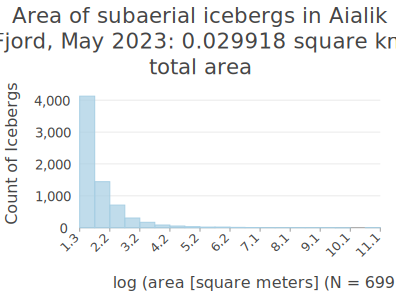

In [95]:
#histogram
h = arcpy.charts.Histogram("area_sqm",
                           binCount=20,
                           dataTransformationType = 'squareRoot')
h.dataSource = fc
h.title = 'Area of subaerial icebergs in ' + study_area +  ' Fjord, ' + ' '.join(year_folder.split('_')) + ': '+ str(round(sum(icebergs)/1e6, 6)) + ' square km total area' 
h.xAxis.title = 'log (area [square meters] (N = ' + str(count_of_icebergs) + ')' 
h.yAxis.title = 'Count of Icebergs'
h.color = ['blue']
h

After creating the final histogram with the log tranformation, export the product as an SVG to the main analysis folder. Before moving to the next acquisition, add the results to the overall `results` data frame to keep track of ice areas per fjord per acquisition for further analysis and accounting of processing.

In [96]:
h.exportToSVG(study_area+year_folder+'_histogram-test.svg')


#### Additing a new entry to the data results table

In [97]:
#results = pd.DataFrame(columns=('month', 'fjord','ice_area_sqkm', 'iceberg_count','aoi_area_sqkm','processing_time')) data format
new_row = pd.Series({'month':year_folder, 
                     'fjord':study_area, 
                     'ice_area_sqkm':round(sum(icebergs)/1e6, 6), 
                     'iceberg_count':count_of_icebergs[0],
                     'aoi_area_sqkm':0,
                     'processing_time':time.strftime("%H:%M:%S", time.gmtime(round(time.perf_counter() - startTime, 1)))})
results = append_row(results, new_row)

"The analysis took: " + str(round(time.perf_counter() - startTime, 1)) + ' s for ' +study_area + ' in ' + year_folder

'The analysis took: 25389.2 s for Aialik in May_2023'

In [98]:
results

,month,fjord,ice_area_sqkm,iceberg_count,aoi_area_sqkm,processing_time
0,May_2023,Aialik,0.029918,6990,0,07:03:09


In [57]:
#results.to_csv('KEFJ_TidewaterGlaciers_Results.csv')

Head back to the top of the workflow to process the next stage.

_______________________________________________________________________

## Results

### Gathering information from processed data

After processing all of the available imagery, it is more efficient to gather the existing results than reprocess each acquisition for new results. Assuming that the above code was used for processing, results can be queried from maps in the catalog and using path names.

Starting with the same method of reading the exisiting acquisition folders, create a list of months/years/fjords from which to build search queries. 

In [54]:
acquisitions = []
for year_folder in year_folders:
    acquisitions.append([os.path.join(main_folder, year_folder, f) for f in os.listdir(os.path.join(main_folder, year_folder)) if os.path.isdir(os.path.join(main_folder, year_folder, f))])
    study_areas = [f for f in os.listdir(os.path.join(main_folder, year_folder)) if os.path.isdir(os.path.join(main_folder, year_folder, f))]
acquisitions = [item for row in acquisitions for item in row] #flatten the list of lists from above loop
print('The following acquisitions have been found in the main folder', main_folder, ':')
print()
for i in acquisitions:
    print(i)
    
results_gdb = r'F:\KEFJ_TidewaterGlaciers_Analysis\Arc\KEFJ_TidewaterGlaciers_Analysis.gdb'

The following acquisitions have been found in the main folder F:\KEFJ_TidewaterGlaciers_Analysis :

F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Northwestern
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\Northwestern
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\Northwestern


Use a `pandas` data frame object to construct the column names for entries in the results table.

In [55]:
results = pd.DataFrame(columns=('month', 'year', 'fjord','ice_area_sqkm', 'iceberg_count','aoi_area_sqkm','processing_time', 'data_path'))
results_path = r'F:\KEFJ_TidewaterGlaciers_Analysis\Results'

Use a `for` loop to search each acquisition folder for the refined polygons. Start by determining if the data were analyzed by looking for a matching map in the catalog. If found, open the iceberg polygons, retrieve their total count and area, measure the size of the AOI, and add these to the results table.

Relevant information will be read out in the console as the code runs. Once all acquisitions in the starting table have been searched for, the results are concatenated to a full table and saved to the main folder.

In [23]:
for acquisition in acquisitions:  
    _, _, year_folder, study_area = acquisition.split('\\')
    year_folder, study_area
    layerPrefix = year_folder + '_' + study_area + '_'
    map_query = study_area + ' ' + year_folder + ' BandStack Classification'
    arcpy.env.workspace = data_path
    arcpy.env.overwriteOutput = True
    aprx = arcpy.mp.ArcGISProject("Current")
    if len(aprx.listMaps(map_query)) == 0:
        print('there is no processed map for', study_area, year_folder)
    else: 
        m = aprx.listMaps(map_query)[0]
        print('accessing results for', study_area, year_folder)
    fc = os.path.join(results_gdb, year_folder+study_area+'_Refined_AreaSubset_final_refined')
    columns = [f.name for f in arcpy.ListFields(fc)]
    df = pd.DataFrame(data=arcpy.da.SearchCursor(fc, columns), columns=columns)
    df.to_csv(os.path.join(results_path,year_folder+study_area+'_results_table.csv'), index=False)
    
    #count of ice
    count_of_icebergs = arcpy.management.GetCount(fc)

    #area of ice
    icebergs = []

    rows = arcpy.SearchCursor(fc)
    for row in rows:
        area = row.getValue("area_sqm")
        icebergs.append(area)

    print('Total area of measured subaerial ice: ' + str(round(sum(icebergs)/1e6, 6)) + ' square km')

    #area of AOI
    proj_folder =  os.path.join(main_folder, year_folder, study_area)
    shapes_path = os.path.join(proj_folder, 'Classification\Shapes')
    files = [f for f in os.listdir(shapes_path) if os.path.isfile(os.path.join(shapes_path, f)) and f.endswith('IceClip.shp')]
    mask_filename = files[0]
    mask = os.path.join(shapes_path, mask_filename)
    
    arcpy.management.CalculateGeometryAttributes(
        in_features=mask,
        geometry_property="area_sqkm AREA",
        length_unit="",
        area_unit="SQUARE_KILOMETERS",
        coordinate_system='PROJCS["NAD_1983_2011_StatePlane_Alaska_4_FIPS_5004",GEOGCS["GCS_NAD_1983_2011",DATUM["D_NAD_1983_2011",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-150.0],PARAMETER["Scale_Factor",0.9999],PARAMETER["Latitude_Of_Origin",54.0],UNIT["Meter",1.0]],VERTCS["unknown",VDATUM["unknown"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]',
        coordinate_format="SAME_AS_INPUT"
    )

    polygons = []

    rows = arcpy.SearchCursor(mask)
    for row in rows:
        area = row.getValue("area_sqkm")
        polygons.append(area)

    aoi_area_sqkm = round(sum(polygons), 2)
    
    print(f'This AOI was {aoi_area_sqkm} sq. km')

    new_row = pd.Series({'month':year_folder.split('_')[0],
                         'year':year_folder.split('_')[1],
                         'fjord':study_area, 
                         'ice_area_sqkm':round(sum(icebergs)/1e6, 6), 
                         'iceberg_count':count_of_icebergs[0],
                         'aoi_area_sqkm':aoi_area_sqkm,
                         'processing_time': 'unknown',
                        'data_path': os.path.join(results_path,year_folder+study_area+'_results_table.csv')})#time.strftime("%H:%M:%S", time.gmtime(round(time.perf_counter() - startTime, 1)))})
    results = append_row(results, new_row)
                     
                     
results.to_csv('KEFJ_TidewaterGlaciers_Results_withoutTimestamp.csv', index=False)

accessing results for Aialik August_2023
Total area of measured subaerial ice: 0.024247 square km
This AOI was 11.75 sq. km
accessing results for McCarty August_2023
Total area of measured subaerial ice: 0.00047 square km
This AOI was 0.29 sq. km
accessing results for Northwestern August_2023
Total area of measured subaerial ice: 0.001508 square km
This AOI was 3.79 sq. km
accessing results for Aialik July_2023
Total area of measured subaerial ice: 0.028173 square km
This AOI was 11.98 sq. km
accessing results for McCarty July_2023
Total area of measured subaerial ice: 0.001834 square km
This AOI was 0.22 sq. km
accessing results for Northwestern July_2023
Total area of measured subaerial ice: 0.008699 square km
This AOI was 10.65 sq. km
accessing results for Aialik May_2023
Total area of measured subaerial ice: 0.036616 square km
This AOI was 23.7 sq. km
accessing results for McCarty May_2023
Total area of measured subaerial ice: 0.000546 square km
This AOI was 3.35 sq. km
accessing r

### Visualization of trends using Matplotlib

In [24]:
import matplotlib.pyplot as plt 

To create individual files with the polygons results' attribute table, run this code again:

In [26]:
for acquisition in acquisitions:  
    _, _, year_folder, study_area = acquisition.split('\\')
    year_folder, study_area
    layerPrefix = year_folder + '_' + study_area + '_'

    fc = os.path.join(results_gdb, year_folder+study_area+'_Refined_AreaSubset_final_refined')

    columns = [f.name for f in arcpy.ListFields(fc)]
    df = pd.DataFrame(data=arcpy.da.SearchCursor(fc, columns), columns=columns)
    df.to_csv(os.path.join(results_path,year_folder+study_area+'_results_table.csv'), index=False)
    

To retrieve the existing data table and read it into a data frame:

In [27]:
results = pd.read_csv('KEFJ_TidewaterGlaciers_Results_withoutTimestamp.csv')
results_path = r'F:\KEFJ_TidewaterGlaciers_Analysis\Results'
results['monthyear'] = results['month'] + str(results['year'])
results

,month,fjord,ice_area_sqkm,iceberg_count,aoi_area_sqkm,processing_time,year,data_path,monthyear
0,August,Aialik,0.024247,5129,11.75,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\Aug...,August0 2023\n1 2023\n2 2023\n3 20...
1,August,McCarty,0.000470,61,0.29,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\Aug...,August0 2023\n1 2023\n2 2023\n3 20...
2,August,Northwestern,0.001508,343,3.79,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\Aug...,August0 2023\n1 2023\n2 2023\n3 20...
3,July,Aialik,0.028173,5876,11.98,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\Jul...,July0 2023\n1 2023\n2 2023\n3 2023...
4,July,McCarty,0.001834,426,0.22,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\Jul...,July0 2023\n1 2023\n2 2023\n3 2023...
5,July,Northwestern,0.008699,1918,10.65,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\Jul...,July0 2023\n1 2023\n2 2023\n3 2023...
6,May,Aialik,0.036616,6216,23.70,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\May...,May0 2023\n1 2023\n2 2023\n3 2023\...
7,May,McCarty,0.000546,135,3.35,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\May...,May0 2023\n1 2023\n2 2023\n3 2023\...
8,May,Northwestern,0.055004,13536,6.31,unknown,2023,F:\KEFJ_TidewaterGlaciers_Analysis\Results\May...,May0 2023\n1 2023\n2 2023\n3 2023\...


Produce clean visualizations for the results in each acquisition:

#### Histogram for a particular fjord over the summer

In [35]:
#Histogram for a particular fjord over the summer
test_sub = results[results.fjord=='Northwestern']

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

n_bins = 20

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(pd.read_csv(test_sub.data_path.iloc[2]).AREA, bins=n_bins)
axs[0].set_title(test_sub.month.iloc[2] + ' '+ str(test_sub.year.iloc[2])+ ' ' + '(N = ' + str(test_sub.iceberg_count.iloc[2]) + ')')

axs[1].hist(pd.read_csv(test_sub.data_path.iloc[1]).AREA, bins=n_bins)
axs[1].set_title(test_sub.month.iloc[1] + ' '+ str(test_sub.year.iloc[1])+ ' ' + '(N = ' + str(test_sub.iceberg_count.iloc[1]) + ')')

axs[2].hist(pd.read_csv(test_sub.data_path.iloc[0]).AREA, bins=n_bins)
axs[2].set_title(test_sub.month.iloc[0] + ' '+ str(test_sub.year.iloc[0])+ ' ' + '(N = ' + str(test_sub.iceberg_count.iloc[0]) + ')')

fig.suptitle(test_sub.fjord.iloc[0] + ' Iceberg Area Distributions (≥ 1.6 sq. meters)')
for ax in axs:
    ax.set_xlabel('Area [sq. m]')
    ax.set_ylabel('Count of Icebergs')
    ax.label_outer()
    
plt.show()

#### Iceberg Counts by Fjord for 2023 months

In [29]:
#Grouped Bar Chart - Icerberg Counts
df = results
fig, ax = plt.subplots()
x = np.arange(len(df.month.unique()))[::-1] #list out months and reverse so May-->July-->August

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.25

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, df.loc[df['fjord'] == 'McCarty', 'iceberg_count'],
            width=bar_width, label = 'McCarty')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, df.loc[df['fjord'] == 'Northwestern', 'iceberg_count'],
            width=bar_width, label = 'Northwestern')

b3 = ax.bar(x + 2*bar_width, df.loc[df['fjord'] == 'Aialik', 'iceberg_count'],
            width=bar_width, label = 'Aialik')

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df.month.unique())

for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = bar.get_height()
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = bar.get_facecolor()
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=9)

#ax.set_xlabel('Acquisition Month')
ax.set_ylabel('Count of Icebergs')
ax.legend()
    
fig.suptitle('Kenai Fjords 2023 Iceberg Counts by Fjord (≥ 1.6 sq. meters)')
plt.show()

#### Total iceberg area by fjord for 2023 months

In [30]:
#Grouped Bar Chart - Icerberg Counts
df = results
fig, ax = plt.subplots()
x = np.arange(len(df.month.unique()))[::-1] #list out months and reverse so May-->July-->August

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.25

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, df.loc[df['fjord'] == 'McCarty', 'ice_area_sqkm'],
            width=bar_width, label = 'McCarty')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, df.loc[df['fjord'] == 'Northwestern', 'ice_area_sqkm'],
            width=bar_width, label = 'Northwestern')

b3 = ax.bar(x + 2*bar_width, df.loc[df['fjord'] == 'Aialik', 'ice_area_sqkm'],
            width=bar_width, label = 'Aialik')

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df.month.unique())

"""
for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = bar.get_height()
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = bar.get_facecolor()
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=9)
"""

ax.set_ylabel('Total Iceberg Area (sq. km)')
ax.legend()
    
fig.suptitle('Kenai Fjords 2023 Total Ice Area by Fjord (≥ 1.6 sq. meters)')
plt.show()

#### Total iceberg area by fjord for 2023 months - Normalized

In [33]:
#Grouped Bar Chart - Icerberg Counts
df = results
df['metric'] = df['ice_area_sqkm']/df['aoi_area_sqkm']
fig, ax = plt.subplots()
x = np.arange(len(df.month.unique()))[::-1] #list out months and reverse so May-->July-->August

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.25

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, df.loc[df['fjord'] == 'McCarty', 'metric'],
            width=bar_width, label = 'McCarty')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, df.loc[df['fjord'] == 'Northwestern', 'metric'],
            width=bar_width, label = 'Northwestern')

b3 = ax.bar(x + 2*bar_width, df.loc[df['fjord'] == 'Aialik', 'metric'],
            width=bar_width, label = 'Aialik')

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df.month.unique())

"""
for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = bar.get_height()
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = bar.get_facecolor()
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=9)
"""

ax.set_ylabel('Total Ice Metric [ice area / aoi area]')
ax.legend()
    
fig.suptitle('Kenai Fjords 2023 Total Ice Normalized by Fjord AOI (≥ 1.6 sq. meters)')
plt.show()

#### Group them by fjord and plot them by month

In [36]:
df = results
pivot = df.pivot(index='month',
                       columns='fjord',
                       values='iceberg_count')
reversed_cats = pivot.index[::-1]
reversed_pivot = pivot.reindex(reversed_cats)

reversed_pivot.plot(legend=False)
for column in reversed_pivot.columns:
    plt.scatter(reversed_pivot.index,
                reversed_pivot[column])
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Month')
plt.ylabel('Iceberg Count')
plt.suptitle('Kenai Fjords 2023 Ice Area by Fjord and Month (≥ 1.6 sq. meters)')

plt.show()

#### Some additional failed tests:

In [373]:
results.groupby('fjord')['iceberg_count'].plot(x = 'month', legend=True)
plt.show()

In [296]:
# Line Chart Testing
data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3))#, sharey=True)
axs[0].bar(results.month, results.iceberg_count)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

plt.show()

### Visualization of trends using KDE, Moving Averages, and ArcGIS

Using a Kernel Density Estimation (KDE), let's try to map the spatial distribution of icebergs in the fjord so we can more easily cross compare between the months.

First, read out the available acquisitions 


In [56]:
main_folder = r'F:\KEFJ_TidewaterGlaciers_Analysis'
results_gdb = r'F:\KEFJ_TidewaterGlaciers_Analysis\Arc\KEFJ_TidewaterGlaciers_Analysis.gdb'
year_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f)) and f != 'Arc' and f != 'Results']
study_areas = [f for f in os.listdir(os.path.join(main_folder, year_folders[0])) if os.path.isdir(os.path.join(main_folder, year_folders[0], f))]

acquisitions = []
for year_folder in year_folders:
    acquisitions.append([os.path.join(main_folder, year_folder, f) for f in os.listdir(os.path.join(main_folder, year_folder)) if os.path.isdir(os.path.join(main_folder, year_folder, f))])
    study_areas = [f for f in os.listdir(os.path.join(main_folder, year_folder)) if os.path.isdir(os.path.join(main_folder, year_folder, f))]
acquisitions = [item for row in acquisitions for item in row] #flatten the list of lists from above loop
print('The following acquisitions have been found in the main folder', main_folder, ':')
print()
for i in acquisitions:
    print(i)

The following acquisitions have been found in the main folder F:\KEFJ_TidewaterGlaciers_Analysis :

F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\August_2023\Northwestern
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\July_2023\Northwestern
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\Aialik
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\McCarty
F:\KEFJ_TidewaterGlaciers_Analysis\May_2023\Northwestern


In [58]:
acquisition = acquisitions[2]
_, _, year_folder, study_area = acquisition.split('\\')
year_folder, study_area
 
#read iceberg polygons
fc = os.path.join(results_gdb, year_folder+study_area+'_Refined_AreaSubset_final_refined')

#set dst path for points from polygons
output_points = os.path.join(results_gdb, year_folder+study_area+'_refined_final_iceberg_weighted_points')

#set density raster out pathname
output_raster = os.path.join(acquisition, 'Classification', 'Layers', year_folder+'_'+study_area+'_density_raster.tif')

#test the read succeeded
columns = [f.name for f in arcpy.ListFields(fc)]
columns, fc

(['OBJECTID', 'Shape', 'Id', 'gridcode', 'area_sqm', 'Id_1', 'COUNT', 'AREA', 'MIN', 'MAX', 'RANGE', 'MEAN', 'STD', 'SUM', 'VARIETY', 'MAJORITY', 'MINORITY', 'MEDIAN', 'PCT90', 'PCT75', 'IN_FID', 'NEAR_FID', 'NEAR_DIST', 'NEAR_RANK', 'origin_mean', 'near_mean', 'difference', 'Shape_Length', 'Shape_Area'], 'F:\\KEFJ_TidewaterGlaciers_Analysis\\Arc\\KEFJ_TidewaterGlaciers_Analysis.gdb\\August_2023Northwestern_Refined_AreaSubset_final_refined')

In [59]:
arcpy.env.overwriteOutput = True
aprx = arcpy.mp.ArcGISProject("Current")

arcpy.env.workspace = r'F:\KEFJ_TidewaterGlaciers_Analysis\Arc\KEFJ_TidewaterGlaciers_Analysis.gdb'
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference(r'F:\KEFJ_TidewaterGlaciers_Analysis\Arc\Nad83_2011_StatePlane4.prj') #nad83 2011 spz4

if len(aprx.listMaps('KDE')) == 0:
    m = aprx.createMap('KDE') #create new map
else: m = aprx.listMaps('KDE')[0]

In [60]:
#set environment parameters
arcpy.env.workspace = r'F:\KEFJ_TidewaterGlaciers_Analysis\Arc\KEFJ_TidewaterGlaciers_Analysis.gdb'
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference(r'F:\KEFJ_TidewaterGlaciers_Analysis\Arc\Nad83_2011_StatePlane4.prj') #nad83 2011 spz4

In [526]:
#calculated weight points from iceberg area
arcpy.management.FeatureToPoint(fc, output_points, 'CENTROID')

<Result 'F:\\KEFJ_TidewaterGlaciers_Analysis\\Arc\\KEFJ_TidewaterGlaciers_Analysis.gdb\\August_2023Northwestern_refined_final_iceberg_weighted_points'>

In [545]:
#run kernel density estimate using weighted points from iceberg area
kde = arcpy.sa.KernelDensity(in_features = output_points,
                             population_field = 'area_sqm',
                             cell_size = '3',
                             #search_radius'1000',
                             area_unit_scale_factor='SQUARE_MAP_UNITS')
kde.save(output_raster)
#runs with cell size 5m, search radius 1 km.


__Loop version__

In [61]:
for acquisition in acquisitions:
    _, _, year_folder, study_area = acquisition.split('\\')
    year_folder, study_area
    #read iceberg polygons
    fc = os.path.join(results_gdb, year_folder+study_area+'_Refined_AreaSubset_final_refined')
    
    #set dst path for points from polygons
    output_points = os.path.join(results_gdb, year_folder+study_area+'_refined_final_iceberg_weighted_points')
    
    #set density raster out pathname
    output_raster = os.path.join(acquisition, 'Classification', 'Layers', year_folder+'_'+study_area+'_density_raster.tif')
    
    #test the read succeeded
    columns = [f.name for f in arcpy.ListFields(fc)]
    
    arcpy.management.FeatureToPoint(fc, output_points, 'CENTROID')
    
    #run kernel density estimate using weighted points from iceberg area
    kde = arcpy.sa.KernelDensity(in_features = output_points,
                             population_field = 'area_sqm',
                             cell_size = '3',
                             #search_radius'1000',
                             area_unit_scale_factor='SQUARE_MAP_UNITS')
    kde.save(output_raster)
    #runs with cell size 5m, search radius 1 km.


In [62]:
# load rasters to map
for acquisition in acquisitions:
    _, _, year_folder, study_area = acquisition.split('\\')
    year_folder, study_area
    #set density raster out pathname
    output_raster = os.path.join(acquisition, 'Classification', 'Layers', year_folder+'_'+study_area+'_density_raster.tif')
    m.addDataFromPath(output_raster)

In [539]:
#set fc
fc = os.path.join(results_gdb, year_folder+study_area+'_Refined_AreaSubset_final_refined')

#set raster output
maverage_raster = os.path.join(acquisition, 'Classification', 'Layers', year_folder+'_'+study_area+'_moving_average_raster.tif')
fc_raster = os.path.join(acquisition, 'Classification', 'Layers', year_folder+'_'+study_area+'_refined_iceberg_raster.tif')

#rasterize fc
arcpy.conversion.FeatureToRaster(fc, 'area_sqm', fc_raster)

#calculate moving average raster
neighborhood = arcpy.sa.NbrRectangle(10,10)
maverage = arcpy.sa.FocalStatistics(fc, neighborhood, 'MEAN')
maverage.save(maverage_raster)



RuntimeError: ERROR 000732: Input Raster: Dataset F:\KEFJ_TidewaterGlaciers_Analysis\Arc\KEFJ_TidewaterGlaciers_Analysis.gdb\August_2023Northwestern_Refined_AreaSubset_final_refined does not exist or is not supported

In [540]:
arcpy.conversion.FeatureToRaster(fc, 'area_sqm', fc_raster)


<Result 'F:\\KEFJ_TidewaterGlaciers_Analysis\\August_2023\\Northwestern\\Classification\\Layers\\August_2023_Northwestern_refined_iceberg_raster.tif'>

In [535]:
#run kernel density estimate using weighted points from iceberg area
kde2 = arcpy.sa.KernelDensity(in_features = output_points,
                             population_field = 'NONE',
                             cell_size = '5',
                             #search_radius'1000',
                             area_unit_scale_factor='SQUARE_MAP_UNITS')
output_raster2 = os.path.join(acquisition, 'Classification', 'Layers', year_folder+'_'+study_area+'_density_raster2.tif')

kde2.save(output_raster2)
#runs with cell size 5m, search radius 1 km.


## Changes in Elevation

### DEM Considerations

McCarty Fjord will be the case study for the elevation change analysis. Its small area compared to Northwestern and Aialik support the testing on this AOI.

Start by creating a new map for McCarty DEMs

In [547]:
if len(aprx.listMaps('McCarty DEM')) == 0:
    m = aprx.createMap('McCarty DEM') #create new map
else: m = aprx.listMaps('McCarty DEM')[0]

Search for and load the DEMs to the new map

In [562]:
study_area = 'Northwestern'

if len(aprx.listMaps(study_area + ' DEM')) == 0:
    m = aprx.createMap(study_area + ' DEM') #create new map
else: m = aprx.listMaps(study_area + ' DEM')[0]
    
year_folders = ['August_2023', 'July_2023', 'May_2023']
main_folder = r'F:\KEFJ_TidewaterGlaciers_Analysis'

In [563]:
for i in range(len(year_folders)):
    dem_path = os.path.join(main_folder, year_folders[i], study_area, 'Elevation')
    files = [f for f in os.listdir(dem_path) if os.path.isfile(os.path.join(dem_path, f)) and f.endswith('tif')]
    dem_filename = files[0]
    m.addDataFromPath(os.path.join(dem_path,dem_filename))
    arcpy.management.CalculateStatistics(dem_filename)

## Discussion

## Misc Excess Code

In [197]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

plot_loghist(test1.AREA, 10)
plt.show()

In [ ]:
#number of individual polygons
#icebergs = m.listLayers(area_subset + '_final_refined')[0]
print('Total number of icebergs measured: ' + str(count_of_icebergs))

In [ ]:
#percent cover

In [ ]:
#moving average raster

In [ ]:
#charts

In [ ]:
arcpy.env.workspace = r'F:\KEFJ_TidewaterGlaciers_Analysis\test'
arcpy.env.overwriteOutput = True
aprx = arcpy.mp.ArcGISProject("Current")

In [ ]:
m = aprx.listMaps('*Test*')[0]

In [ ]:
fc = 'McCarty_SegmentedPolygons_BandStack_ValBNDVI_ENDVI_Segmented10_10_25_ClippedToWater'

In [35]:
import matplotlib.pyplot as plt

In [17]:
help(c.color)

No Python documentation found for 'customColor'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.



In [32]:
c = arcpy.charts.Histogram("area_sq_m",
                           binCount=20,
                           dataTransformationType = 'logarithmic')
c.dataSource = fc
x = 'test'
c.title = 'Area of Subaerial Icebergs in ' + x +  ' fjord'
c.xAxis.title = 'log (area [sq. m])' 
c.yAxis.title = 'Count'
c.color = ['#fac9c7']

b = arcpy.charts.Histogram("area_sq_m",
                           binCount=20,
                           dataTransformationType = 'squareRoot')
b.dataSource = fc
x = 'test'
b.title = 'Area of Subaerial Icebergs in ' + x +  ' fjord'
b.xAxis.title = 'log (area [sq. m])' 
b.yAxis.title = 'Count of Polygons'
b.color = ['blue']

c.exportToSVG('red.svg', width=750, height=400)
b.exportToSVG('blue.svg', width=750, height=400)
